# Continuous Control

---

Follow the instructions below to get started!

### Setup the Environment

Run the next code cell to setup the environment.  This line might take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
workspace = 'udacity'   # set to udacity if running in the workspace
if workspace == 'udacity':
    !pip -q install ./python

environments = {
    'local-linux-single-agent': './env/single_agent/Reacher_Linux/Reacher.x86',
    'local-linux-multi-agent': './env/multi_agent/Reacher_Linux/Reacher.x86',  
    'local-linux64-single-agent': './env/single_agent/Reacher_Linux/Reacher.x86_64',
    'local-linux64-multi-agent': './env/multi_agent/Reacher_Linux/Reacher.x86_64',        
    'local-macos-single-agent': './env/single_agent/Reacher.app',
    'local-macos-multi-agent': './env/multi_agent/Reacher.app',
    'local-windows-single-agent': './env/single_agent/Reacher_Windows_x86/Reacher.exe',
    'local-windows-multi-agent': './env/multi_agent/Reacher_Windows_x86/Reacher.exe',  
    'local-windows64-single-agent': './env/single_agent/Reacher_Windows_x86_64/Reacher.exe',
    'local-windows64-multi-agent': './env/multi_agent/Reacher_Windows_x86_64/Reacher.exe',       
    'udacity-one-agent': '/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64',
    'udacity-multi-agent': '/data/Reacher_Linux_NoVis/Reacher.x86_64'
}


env_file_name = environments['udacity-one-agent']

### Runtime Initialization

Import all the packages required to run this notebook and setup the Unity Environment

In [2]:
import numpy as np
from collections import namedtuple, deque
from datetime import datetime

from unityagents import UnityEnvironment

import random
import torch
from replaybuffer import ReplayBuffer
from ddpg.agent import Agent as DDPG_Agent

import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name=env_file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Get required properties from the environment

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Train the agent in the Environment

This implementation using Deep Deterministic Policy Gradients (DDPG) algorithm to solve the problem.

### Architecture

#### Agent

The Agent uses the "Actor-Critic" that is a method which uses funcation approximation to learn a policy for any value function to solve the continuous action space. The Actor and Critic are 2 networks that do the following:
1. Actor - Takes in a state and outputs the distribution over actions.
2. Critic - Approximate the maximizer over the Q values of the next state that trains the action

The Agent also uses a ReplyBuffer to interact with the environment for training. It uses the Eplison Greedy method to select the action with a starting epsilon of 1.0. The epsilon is decayed over the episodes using a decay rate of 0.995 with an ending epsilon of 0.01.
   - Replay Buffer: It stores the experience that the agent observes, allowing us to reuse this data later. This allows the agent to sample the transistions randomly reducing the correlation in a batch. This has been shown to stablize and improve the DQN training. The buffer is a a cyclic buffer of bounded size that holds the experiences observed recently. It also implements a .sample() method for selecting a random batch of experiences for training. Each experience stored is actually a NamedTuple containing a single a named tuple representing a single interaction with the environment. It essentially maps (state, action) pairs to their (next_state, reward, done) result.
   - Target network: This network is compared to the local network minimize the error better the 2 to maximize the reward to solve the task. The agent randomly initialized it at a start and it is updated everytime the buffer hits the batch size. The update is performed by picking random samples from the Replay Buffer to get the bast action for a given state.
   - Local network: This network takes a state as input and outputs an action. It makes use of a Ornstein-Uhlenbeck process to perform exploration of actions during the training process

It takes in the following parameters during contruction:
1. device - Allows the training to switch between running on the CPU or GPU
2. config dictinarary that contains the key values 
    - "state_size": dimension of each state
    - "action_size": dimension of each action
    - "buffer_size": replay buffer size
    - "batch_size": minibatch size
    - "random_seed": random seed
    - "gamma": discount factor
    - "tau": for soft update of target parameters
    - "lr_actor": learning rate of the actor 
    - "lr_critic": learning rate of the critic
    - "weight_decay": L2 weight decay
    - "learn_every": learn from replay buffer every time step
    - "learn_batch_size": number of batches to learn from replay buffer every learn_every time step
    - "grad_clip": gradient value to clip at for critic
    - "eps_start": starting value of epsilon, for epsilon-greedy action selection
    - "eps_end": minimum value of epsilon
    - "eps_decay": multiplicative factor (per episode) for decreasing epsilon
    - "print_every": Print average every x episode,
    - "episode_steps": Maximum number of steps to run for each episode
    - "mu": mu for noise
    - "theta": theta for noise 
    - "sigma": sigma for noise

#### Contructor

The constructor of the agent takes care of creating the Actor local and target network, Critic local and target network, an Adam optimizer, Ornstein-Uhlenbeck noise.

#### Methods
1. act
This method is called with the current state which the agent uses with the Ornstein-Uhlenbeck noise process to explore the next action to perform.
2. step
This method takes in the `state, action, reward, next_state, done, timestep` values that were obtained from performing the action obtained from the act method previously. Internally it stores the inputs into the ReplayBuffer. And during every `learn_every` step it will trigger the learn method on a random sample of responses if the memory capacity is greater than the `batch_size`
3. reset
This method resets the noise process during learning
4. learn_episode
This method is called by the runner to learn from all time steps in an episode. The runner will call it when it finds the best episode average. It makes the network converge faster
5. learn
This method will calculate the target rewards and calculate the loss against the Q values in the local network using the `MSELoss` function. It will then perform any required optimization using the optimizer. And it will trigger the `soft_update` method. It also decays the eplison value that is used to generate the noise
6. soft_update
This method will perform an update on the parameters in the target network.

#### Network

##### Actor
Forward pass Network that has 3 feed forward layers and a Batch Normalization Layer:
1. fcs1 - in:state_size, out:fcs1_units
2. bc1 - in:fcs1_units, out:fcs1_units
3. relu: activation for adding nonlinearity
4. fc2 - in:fcs1_units+action_size, out:fc2_units
5. relu: activation for adding nonlinearity
5. fc3: in:fc2_units, out:1

##### Critic
Forward pass Network mapping (Stae, action) pairs -> Q-values that has 3 feed forward layers and a Batch Normalization Layer:
1. fcs1 - in:state_size, out:fc1_units
2. bc1 - in:fc1_units, out:fc1_units
3. relu: activation for adding nonlinearity
4. fc2 - in:fc1_units, out:fc2_units
5. relu: activation for adding nonlinearity
5. fc3: in:fc2_units, out:1

Starting training 2019-11-12 15:31:40.316389
Episode 20	Last 100 Episodes Moving Avg: 0.5 took 0:00:05.957487: 1.2499999720603228
Episode 40	Last 100 Episodes Moving Avg: 0.7 took 0:00:06.051023: 2.0099999550729991
Episode 60	Last 100 Episodes Moving Avg: 1.0 took 0:00:06.046615: 3.0299999322742224
Episode 80	Last 100 Episodes Moving Avg: 1.1 took 0:00:06.221100: 3.0299999322742224
Episode 100	Last 100 Episodes Moving Avg: 1.4 took 0:00:06.117556: 5.119999885559082
Episode 120	Last 100 Episodes Moving Avg: 1.8 took 0:00:06.118579: 5.999999865889549
Episode 140	Last 100 Episodes Moving Avg: 2.5 took 0:00:06.238941: 8.509999809786677
Episode 160	Last 100 Episodes Moving Avg: 3.1 took 0:00:06.159753: 9.779999781399965
Episode 180	Last 100 Episodes Moving Avg: 3.8 took 0:00:06.140130 9.7799997813999655
Episode 200	Last 100 Episodes Moving Avg: 4.6 took 0:00:06.248723: 9.779999781399965
Episode 220	Last 100 Episodes Moving Avg: 5.8 took 0:00:06.191545: 13.0899997074157044
Episode 240	Last 1

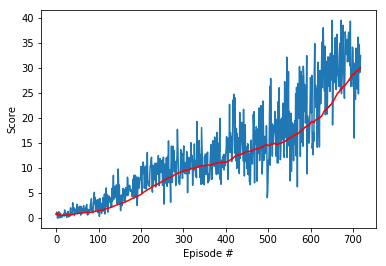

In [5]:
config = { 
    "state_size": state_size,    # dimension of each state
    "action_size": action_size,  # dimension of each action
    "buffer_size": int(1e10),    # replay buffer size
    "batch_size": 128,           # minibatch size
    "random_seed": None,         # random seed
    "gamma": 0.99,               # discount factor
    "tau": 1e-3,                 # for soft update of target parameters
    "lr_actor": 1e-4,            # learning rate of the actor 
    "lr_critic": 1e-3,           # learning rate of the critic
    "weight_decay": 0,           # L2 weight decay
    "learn_every": 50,           # learn from replay buffer every time step
    "learn_batch_size": 10,      # number of batches to learn from replay buffer every learn_every time step
    "grad_clip": 1.0,            # gradient value to clip at for critic
    "eps_start": 1.0,            # starting value of epsilon, for epsilon-greedy action selection
    "eps_end": 0,                # minimum value of epsilon
    "eps_decay": 1e-8,           # multiplicative factor (per episode) for decreasing epsilon
    "print_every": 20,           # Print average every x episode,
    "episode_steps": 1000,       # Maximum number of steps to run for each episode
    "mu": 0,                     # mu for noise
    "theta": 0.15,               # theta for noise 
    "sigma": 0.01                # sigma for noise
}

def ddpg(agent, n_episodes=1000):
    mean_scores = []                               # list of mean scores from each episode
    last_100_avgs = []                             # moving average tracker of mean of last 100 episodes
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes
    best_scores = 0
    print(f'Starting training {datetime.now()}')
    for i_episode in range(1, n_episodes+1):
        start_datetime = datetime.now()
        env_info = env.reset(train_mode=True)[brain_name] 
        states = env_info.vector_observations 
        scores = np.zeros(num_agents)
        
        agent.reset()
        for t in range(config["episode_steps"]):
            print(f'\rEpisode {i_episode}\tTimestep: {t}\tScore: {scores}\tBest Episode Score: {best_scores}', end='\r')

            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)     
            
            states = next_states
            scores += rewards
            if np.any(dones):
                print(f'\rEpisode {i_episode}\tDone at step {t}')
                break
                
        episode_scores = np.mean(scores)
        mean_scores.append(np.mean(scores))             # save mean score for the episode
        scores_window.append(mean_scores[-1])           # save mean score to window
        last_100_avgs.append(np.mean(scores_window))    # save moving average
        
        if episode_scores > best_scores:
            best_scores = episode_scores
            agent.learn_episode()
        
        if i_episode % config["print_every"] == 0:
            print(f'\rEpisode {i_episode}\tLast 100 Episodes Moving Avg: {last_100_avgs[-1]:.1f} took {datetime.now() - start_datetime}')
                  
        if last_100_avgs[-1] >= 30.0 and i_episode >= 100:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: { last_100_avgs[-1]:.2f}') 
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return mean_scores, last_100_avgs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
memory = ReplayBuffer(device=device, config=config)
agent = DDPG_Agent(memory=memory, device=device, config=config)
scores, avgs = ddpg(agent, n_episodes=1000)    # The maximum step before the episode will end is 1,000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [6]:
env.close()

#### Summary

Various hyperparameters were modified during the training sessions to find the sweet spot to make the agent perform better. The final run achieved the acheived the required running total of average score of 30 over 100 episodes. This run was solved from episode 619 to 719. The following was done in the implementation:

1. A best_scores value was tracked in the running loop, when an episode exceeds the currect best. The runner will make the agent learn from all the steps in that episode. This make the agent train faster form the testing
2. episode_steps was set to 1000, this was tested to be the maximum step before the environment will output a done which terminates the episode
3. n_episodes was set to 1,000 this run was able to complete by 719, but from testing depending on the agents exploration during the run it might require to be a larger
4. buffer_size was set to int(1e10), this consumes more memory but based the calculation of 719 X 1,000 = 719,000. I expanded it as I had a training run using int(1e10) that went into a local minimum since 100,000 will start ejecting older values after 100 episodes.
5. sigma found that lowering this number which reduces the noise seem to improve the scores
6. eps_decay this is set to a low number that adds more noise at the start to introduce randomness that encourages exploration. As the episodes grow it slowly decays and reduces the noise to reduce action exploration

#### Ideas for Future Work
1. A multi agent algorithm can be tested which is supposed to be more stable than DDPG
2. Introducing Parameter noise that adds adaptive noise to the parameters of the neural network policy ranter than to its action space This injects randomness directly into the parameters of the agent, altering the types of decisions it makes such that they always fully depend on what the agent currently senses. It is suppose to help algorithms explore environments more effectively leading to higher scores and more elegant behaviours. (Reference -> https://openai.com/blog/better-exploration-with-parameter-noise/)
3. Prioritized Experience Replay the implementation has a method that learns from the time steps every time it encounters an episode that beats the last best score found. More exploration into the Prioritized Experience Replay described by (https://arxiv.org/abs/1511.05952) to replay important transitions more frequently, and therefore learn more efficiently might be explored.